# OSHA Exposure Data: Training Set Preparation, Analysis, & Modeling Insights
**Author:** Jacob Kvasnicka <br>
**Date:** January 7, 2025

## Background
We are developing a high-throughput modeling framework to predict a chemical's Margin of Exposure (MOE) by integrating:

1. **QSAR Model**:  
   - Predicts human-equivalent Points of Departure (POD)  

2. **Machine Learning Exposure Model**:  
   - Predicts exposure concentrations in U.S. workplaces  

The POD models demonstrated sufficient performance:  
- Typical prediction error within a factor of 5 mg/m³  
- Approximately 50% of the variance explained  

---

### Current Objective  

The current objective is to develop an **exposure model** based on a machine-learning approach.  

The target variable is an exposure concentration directly comparable to the POD, enabling risk-based chemical pre-prioritization.  

The model should be **user-friendly**, requiring only one or two inputs:  
1. A chemical's DTXSID  
2. Possibly, the industry (NAICS) code for the industry being evaluated  

**Hypothesis**: *Different industries have distinct exposure patterns influenced by the processes and tasks associated with those industries, which needs to be accounted for in addition to chemistry.*

---

## Notebook Organization  

This notebook is organized into three main sections:  

1. **Overview of Exposure Datasets and Cleaning Pipelines**:  
   - Highlights commonalities and differences between CEHD and USIS datasets.  
   - Summarizes the workflows for preparing cleaned CEHD and USIS datasets for machine learning.  

2. **Training Set Preparation**:  
   - Describes the steps for deriving a representative target variable for the exposure model.  

3. **Data Visualization & Modeling Insights**:  
   - Six figures highlighting different aspects and challenges of the exposure training data.  
.

In [1]:
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import math
from scipy.stats import linregress
from scipy.stats import spearmanr 
from scipy.stats import f_oneway
import joblib

from config_management import UnifiedConfiguration
from raw_processing import (
    cehd_cleaning, 
    usis_cleaning,
    osha_cleaning,
    cehd_processing,
    usis_processing,
    osha_processing
)
import data_management
import plot

config = UnifiedConfiguration()

## 1. Overview of Exposure Datasets and Cleaning Pipelines

We are using two OSHA datasets, collectively comprising the largest database of industrial hygiene air measurements in North America:

- **USIS (United States Information System):** Aggregates two datasets, including the legacy Integrated Management Information System (IMIS) (1971–2015) and its next-generation replacement, OSHA Information System (OIS) (2011–2021).

- **CEHD (Chemical Exposure Health Data):** Includes all OSHA measurements analyzed by the Salt Lake Technical Center from 1984 through the latest dataset (2023 release). Includes some overlapping records with USIS.

---

## Data Cleaning Pipeline for CEHD and USIS Datasets

I implemented a data cleaning pipeline for the CEHD and USIS datasets to ensure consistent, high-quality data for modeling. This process harmonized the datasets into a unified format, enabling them to be combined into a single training set. The cleaning steps generally included the following:

- **Removed Nonpersonal Samples:**  
  Retained only personal samples collected in the worker's breathing zone to ensure that the concentration measurements represent external exposure, as opposed to area samples.

- **Converted to Mass Concentration:**  
  Converted units of PPM and % to mg/m³ to ensure that the concentration measurements are directly comparable to the Points of Departure (PODs) with the same units. Records with units that could not be converted (e.g., fibers per cubic centimeter) were removed.

- **Mapped Substance Names to DTXSIDs:**  
  Matched raw substance names to DTXSIDs, enabling retrieval of chemical-specific information from external sources (e.g., physical-chemical properties for modeling). Substances that could not be matched to a DTXSID were removed.

- **Harmonized NAICS Codes:**  
  Standardized historical SIC and NAICS codes in the dataset to the most recent 2022 NAICS cycle for consistency.

- **Filtered Full-Shift TWAs (USIS):**  
  Removed short-term samples aimed at capturing maximum exposures during a given workshift. Retained only full-shift TWA measurements, representative of subchronic or chronic exposure for comparison with the PODs.

In [ ]:
usis_cleaner = usis_cleaning.UsisCleaner(config.usis, config.path, config.comptox)
cehd_cleaner = cehd_cleaning.CehdCleaner(config.cehd, config.path, config.comptox)

In [ ]:
raw_usis = usis_cleaner.load_raw_data()
raw_cehd = cehd_cleaner.load_raw_data()

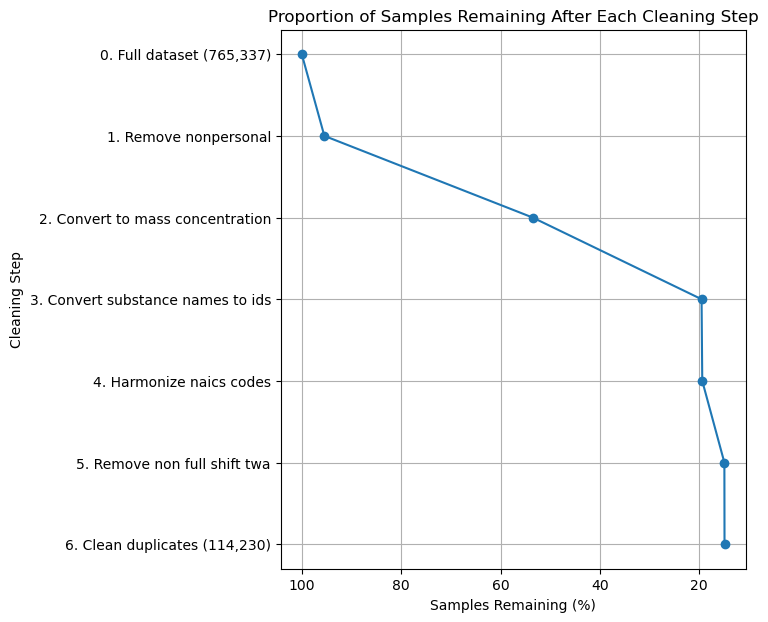

In [12]:
usis_initial_count = len(raw_usis)

_ = plot.cumulative_changes(
    config.path['usis_log_file'], 
    usis_initial_count
)

**NOTE:** CEHD has more samples, because the USIS data involve aggregated full-shift Time Weighted Average (TWA) concentrations, whereas the raw CEHD contains partial-shift measurements that have not yet been converted into a full-shift TWA.

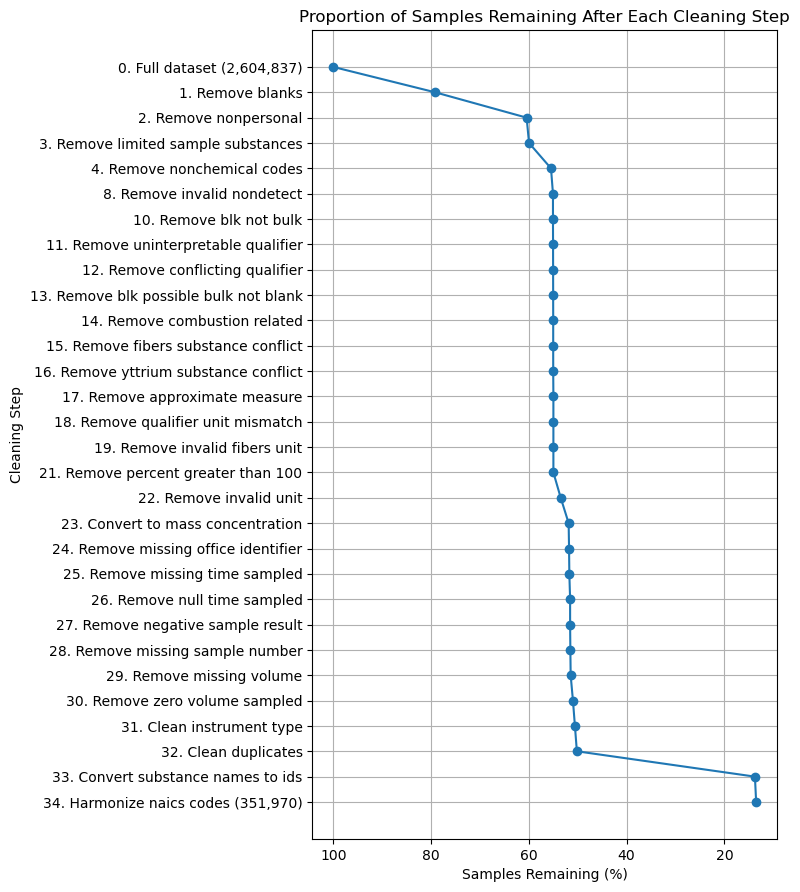

In [13]:
cehd_initial_count = len(raw_cehd)

_ = plot.cumulative_changes(
    config.path['cehd_log_file'], 
    cehd_initial_count
)

## 2. Training Set Preparation

Fortunately, the POD predictions:
- Are expressed in air concentration units [mg/m³].
- Were derived from chronic studies and adjusted from animals to humans using a "Dosimetric Adjustment Factor."
- Were "calibrated" to regulatory/authoritative PODs which were adjusted to a consistent continuous exposure pattern. 

Thus, our approach is to directly compare the POD in concentration units with a continuous personal air concentration to derive a *Margin of Exposure (MOE)*. The derivation of this personal air concentration is detailed below.

---

### Hierarchical Structure of OSHA Measurement Data

The derivation of the target variable accounts for the hierarchical nature of the OSHA data. Specifically, the OSHA data are organized as follows:

1. **Sampling Number** (most specific level):
   - Unique identifier tied to the Air Sampling Worksheet (OSHA 91A).
   - Represents an individual “evaluation” for a worker (e.g., a worker’s full shift).
   - Provides a link between the USIS and CEHD datasets.

2. **Inspection Number**:
   - Unique identifier for each OSHA inspection of a specific workplace.
   - May involve several workers, and therefore several sampling numbers.

3. **Industry Classification** (least specific level):
   - Four-digit **Standard Industrial Classification (SIC)** codes (1972 or 1987).
   - Six-digit **North American Industry Classification System (NAICS)** codes (introduced after 1997).
   - The data cleaning pipeline harmonized these codes to the latest 2022 cycle.
  
---

### Steps for Deriving the Target Variable

#### Step 1: Calculate Full-Shift TWA Concentrations
- **USIS Data**: The raw data were already aggregated into full-shift TWAs where applicable. Other sample types were excluded, including peak exposures, short-term exposure limits, and ceiling limits.
- **CEHD Data**:
  - Treated multiple records tied to a single sampling number and chemical as sequential partial-shift measurements.
  - Aggregated these measurements to calculate total sampling time and a TWA concentration, following the approach of Sarazin et al. (2018).
 
**Reference:** *Sarazin, P., Burstyn, I., Kincl, L., Friesen, M. C., & Lavoué, J. (2018). Characterization of the selective recording of workplace exposure measurements into OSHA’s IMIS Databank. Annals of work exposures and health, 62(3), 269-280.*

---

#### Step 2: Convert TWAs to Continuous Equivalents
Given the intermittant nature of a typical work schedule, I converted full-shift TWAs into continuous-equivalent concentrations following EPA Risk Assessment Guidance for Superfund (2009). 

##### Equation 1:
$$
EC = \frac{CA \times ET \times EF \times ED}{AT}
$$
Where:
- **CA**: Air concentration (mg/m³) [in this case, measured by OSHA]
- **ET**: Exposure time (hours/day)
- **EF**: Exposure frequency (days/year)
- **ED**: Exposure duration (years)
- **AT**: Averaging time, calculated as $ED \times 365 (days/year) \times 24 (hours/day)$

**Assumed Parameters (Typical Work Schedule)**:
- ET = 8 hours/day
- EF = 250 days/year
- ED = 25 years

**Reference:** *United States Environmental Protection Agency (2009). Risk assessment guidance for superfund: Volume I: Human health evaluation manual (Part F, supplemental guidance for inhalation risk assessment) (EPA-540-R-070-002; OSWER 9285.7-82). Office of Superfund Remediation and Technology Innovation.*

---

#### Step 3: Aggregate Measurement Data
Each training set sample represents a typical exposure for a given chemical and industry (NAICS). The following aggregation workflow was applied:

1. **Inspection-Level Aggregation**:
   - Calculated the *median exposure concentration* across sampling numbers (workers) within each inspection.
   - Resulting value represents the *typical exposure for a worker* in the inspected workplace.
   
2. **Industry-Level Aggregation**:
   - Calculated the *median* of the inspection-level concentrations (Step 1 above) across all inspections within a given industry (NAICS).
   - The resulting value represents the *typical exposure in a specific industry*.
   - A sensitivity analysis enables different industry representations based on the NAICS code hierarchical organization scheme: e.g., sector versus the more specific subsector aggregation.

---

#### Step 4: Combine USIS & CEHD into a Single Training Set

To maximize the sample size and coverage of the training set, the two datasets were harmonized and combined. USIS was used as the primary dataset, and CEHD data were added where no USIS data exists.

In [4]:
usis_data = pd.read_feather(config.path['test_usis_file']).set_index('index')
cehd_data = pd.read_feather(config.path['test_cehd_file']).set_index('index')

twa_usis = usis_processing.full_shift_twa_per_sampling(usis_data, **config.usis)
twa_cehd = cehd_processing.full_shift_twa_per_sampling(cehd_data, **config.cehd)
twa_combined = osha_processing.combine_exposure_datasets(twa_usis, twa_cehd)

twa_combined

DTXSID         naics_id  inspection_number  sheet_number
DTXSID2021284  811490    117919878          400667291       221.192011
                                            400667317       122.912991
                                            400667309       132.245777
DTXSID3031022  332323    112520028          400667697         0.300000
DTXSID8021482  811490    10239978           910584754       106.895706
                                                               ...    
DTXSID9049617  926150    313134538          435731773         0.000000
                         313528424          435593488         0.000000
                         315058396          914738083         0.000000
                         896579             132511            0.000000
                         941801             161154            0.000000
Length: 226720, dtype: float64

In [2]:
usis_targets = data_management.read_targets(config.path['usis_target_dir'])
cehd_targets = data_management.read_targets(config.path['cehd_target_dir'])
combined_targets = data_management.read_targets(config.path['target_dir'])

sorted_naics_levels = config.cehd['naics_levels']
usis_targets = {k : usis_targets[k] for k in sorted_naics_levels}
cehd_targets = {k : cehd_targets[k] for k in sorted_naics_levels}
combined_targets = {k : combined_targets[k] for k in sorted_naics_levels}

opera_features = pd.read_parquet(config.path['opera_features_file'])

In [16]:
combined_targets['sector']

DTXSID          naics_id
DTXSID0020151   32           0.074324
                33          10.882086
DTXSID0020153   32          28.086929
                33           1.022417
                44           4.727942
                              ...    
DTXSID9051660   23           0.002283
                33           0.026712
                81           0.005365
DTXSID9058789   33           0.015297
DTXSID90893948  33           0.225231
Name: mg_per_m3, Length: 3059, dtype: float64

In [15]:
combined_targets['subsector']

DTXSID          naics_id
DTXSID0020151   325          0.074324
                333         10.882086
DTXSID0020153   325         28.086929
                336          1.022417
                441          4.727942
                              ...    
DTXSID9051660   336          0.031963
                337          0.066210
                811          0.005365
DTXSID9058789   332          0.015297
DTXSID90893948  331          0.225231
Name: mg_per_m3, Length: 6782, dtype: float64

In [17]:
combined_targets['industry_group']

DTXSID          naics_id
DTXSID0020151   3256         0.074324
                3339        10.882086
DTXSID0020153   3255        56.026109
                3259         0.147749
                3369         1.022417
                              ...    
DTXSID9051660   3372         0.066210
                8113         0.006164
                8114         0.004566
DTXSID9058789   3323         0.015297
DTXSID90893948  3315         0.225231
Name: mg_per_m3, Length: 12262, dtype: float64

## 3. Data Visualization & Modeling Insights

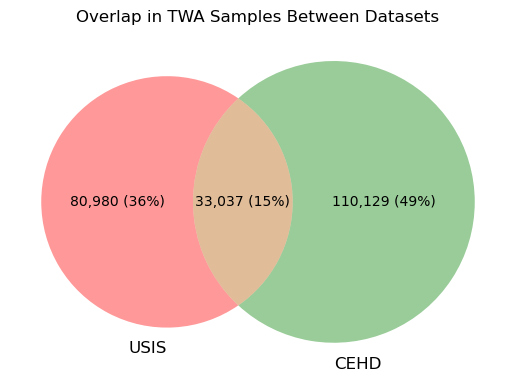

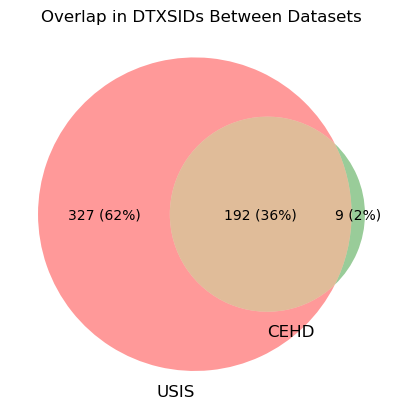

In [26]:
# NOTE: Chemical ID & sampling number forms the link between datasets
usis_chem_ids = twa_usis.index.get_level_values(config.usis['chem_id_col'])
usis_sampling_nos = twa_usis.index.get_level_values(config.usis['sampling_number_col'])
cehd_chem_ids = twa_cehd.index.get_level_values(config.cehd['chem_id_col'])
cehd_sampling_nos = twa_cehd.index.get_level_values(config.cehd['sampling_number_col'])

plot.dataset_overlap_venn(
    set(zip(usis_chem_ids, usis_sampling_nos)), 
    set(zip(cehd_chem_ids, cehd_sampling_nos)), 
    title='Overlap in TWA Samples Between Datasets',
    write_path='figures/twa_samples_venn.png'
)

plot.dataset_overlap_venn(
    set(usis_chem_ids.unique()), 
    set(cehd_chem_ids.unique()), 
    title='Overlap in DTXSIDs Between Datasets',
    write_path='figures/chemicals_venn.png'
)

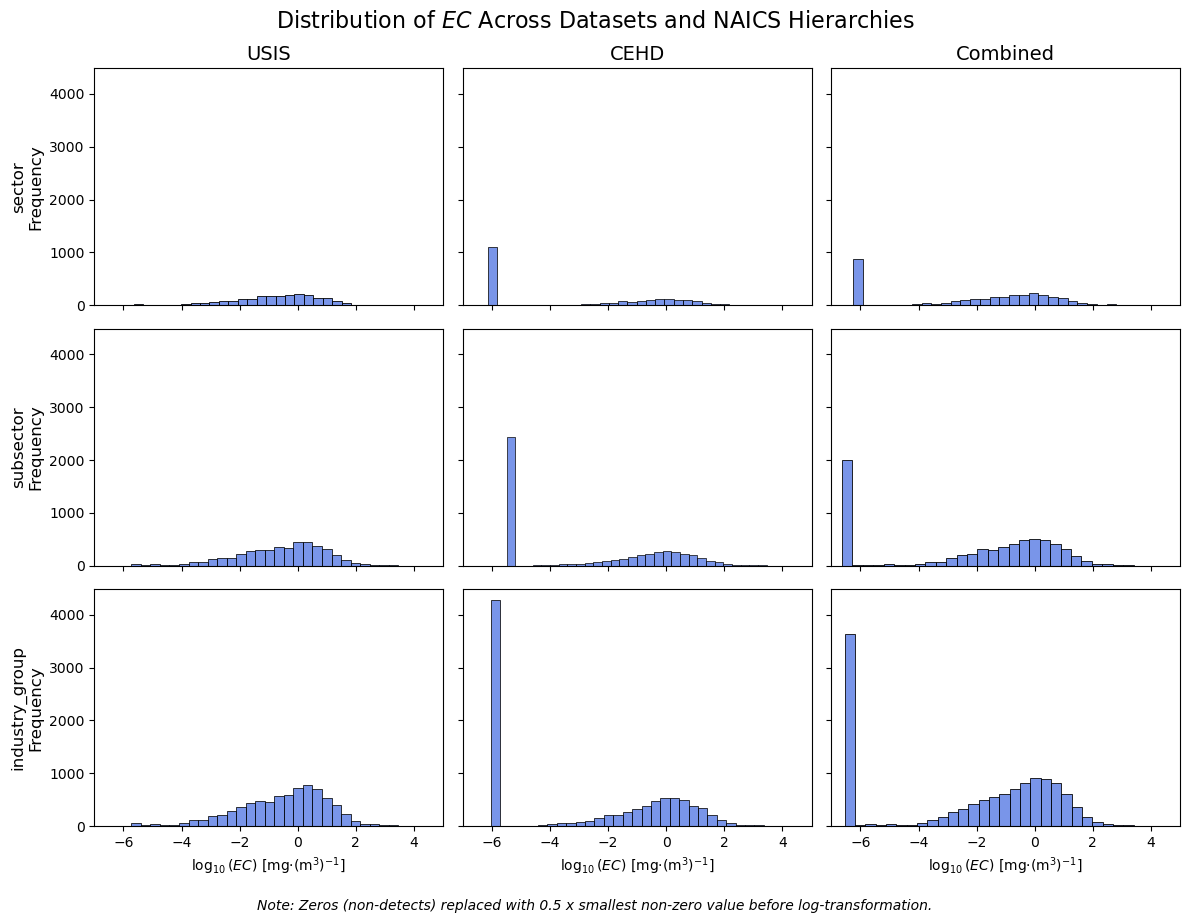

In [3]:
targets_dict = {
    'USIS' : usis_targets, 
    'CEHD' : cehd_targets,
    'Combined' : combined_targets
}

plot.histogram_grid(targets_dict, write_path='figures/histogram_grid.png')

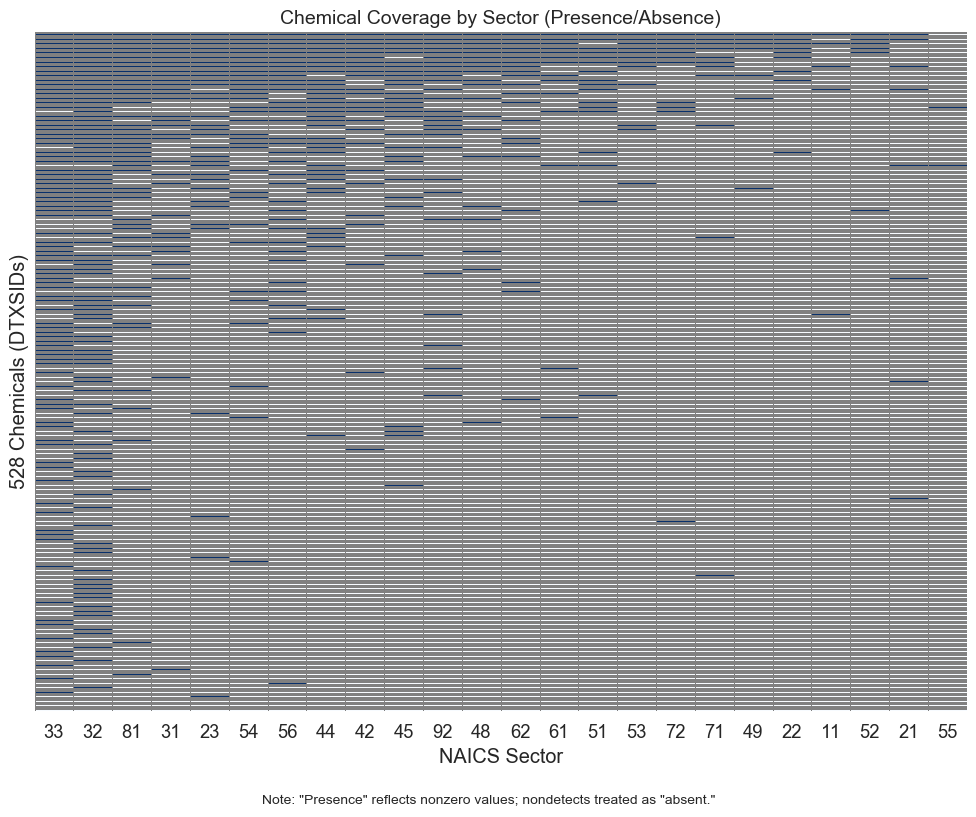

In [7]:
plot.chemical_coverage_heatmap(
    combined_targets['sector'], 
    write_path='figures/chemical_coverage_heatmap.png'
)

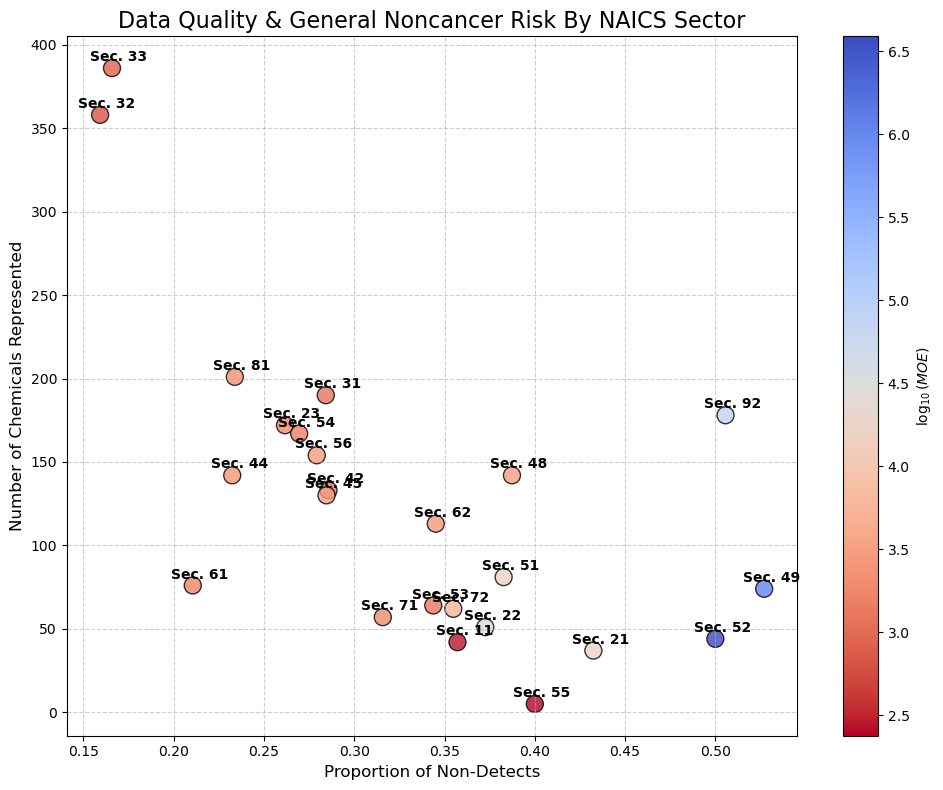

In [3]:
pod_data = pd.read_parquet(config.path['pod_file'])

pods = pod_data['general'].copy()

exposures = plot.preprocess_target(combined_targets['sector'], log10=False).copy()
pods = (
    pods
    .reindex(exposures.index.get_level_values('DTXSID'))
    .to_frame()
    .set_index(exposures.index)
    .squeeze()
)

moes = np.log10(pods / exposures)

plot.naics_level_data_summary(
    combined_targets['sector'], 
    moes, 
    write_path='figures/sector_data_quality.png'
)

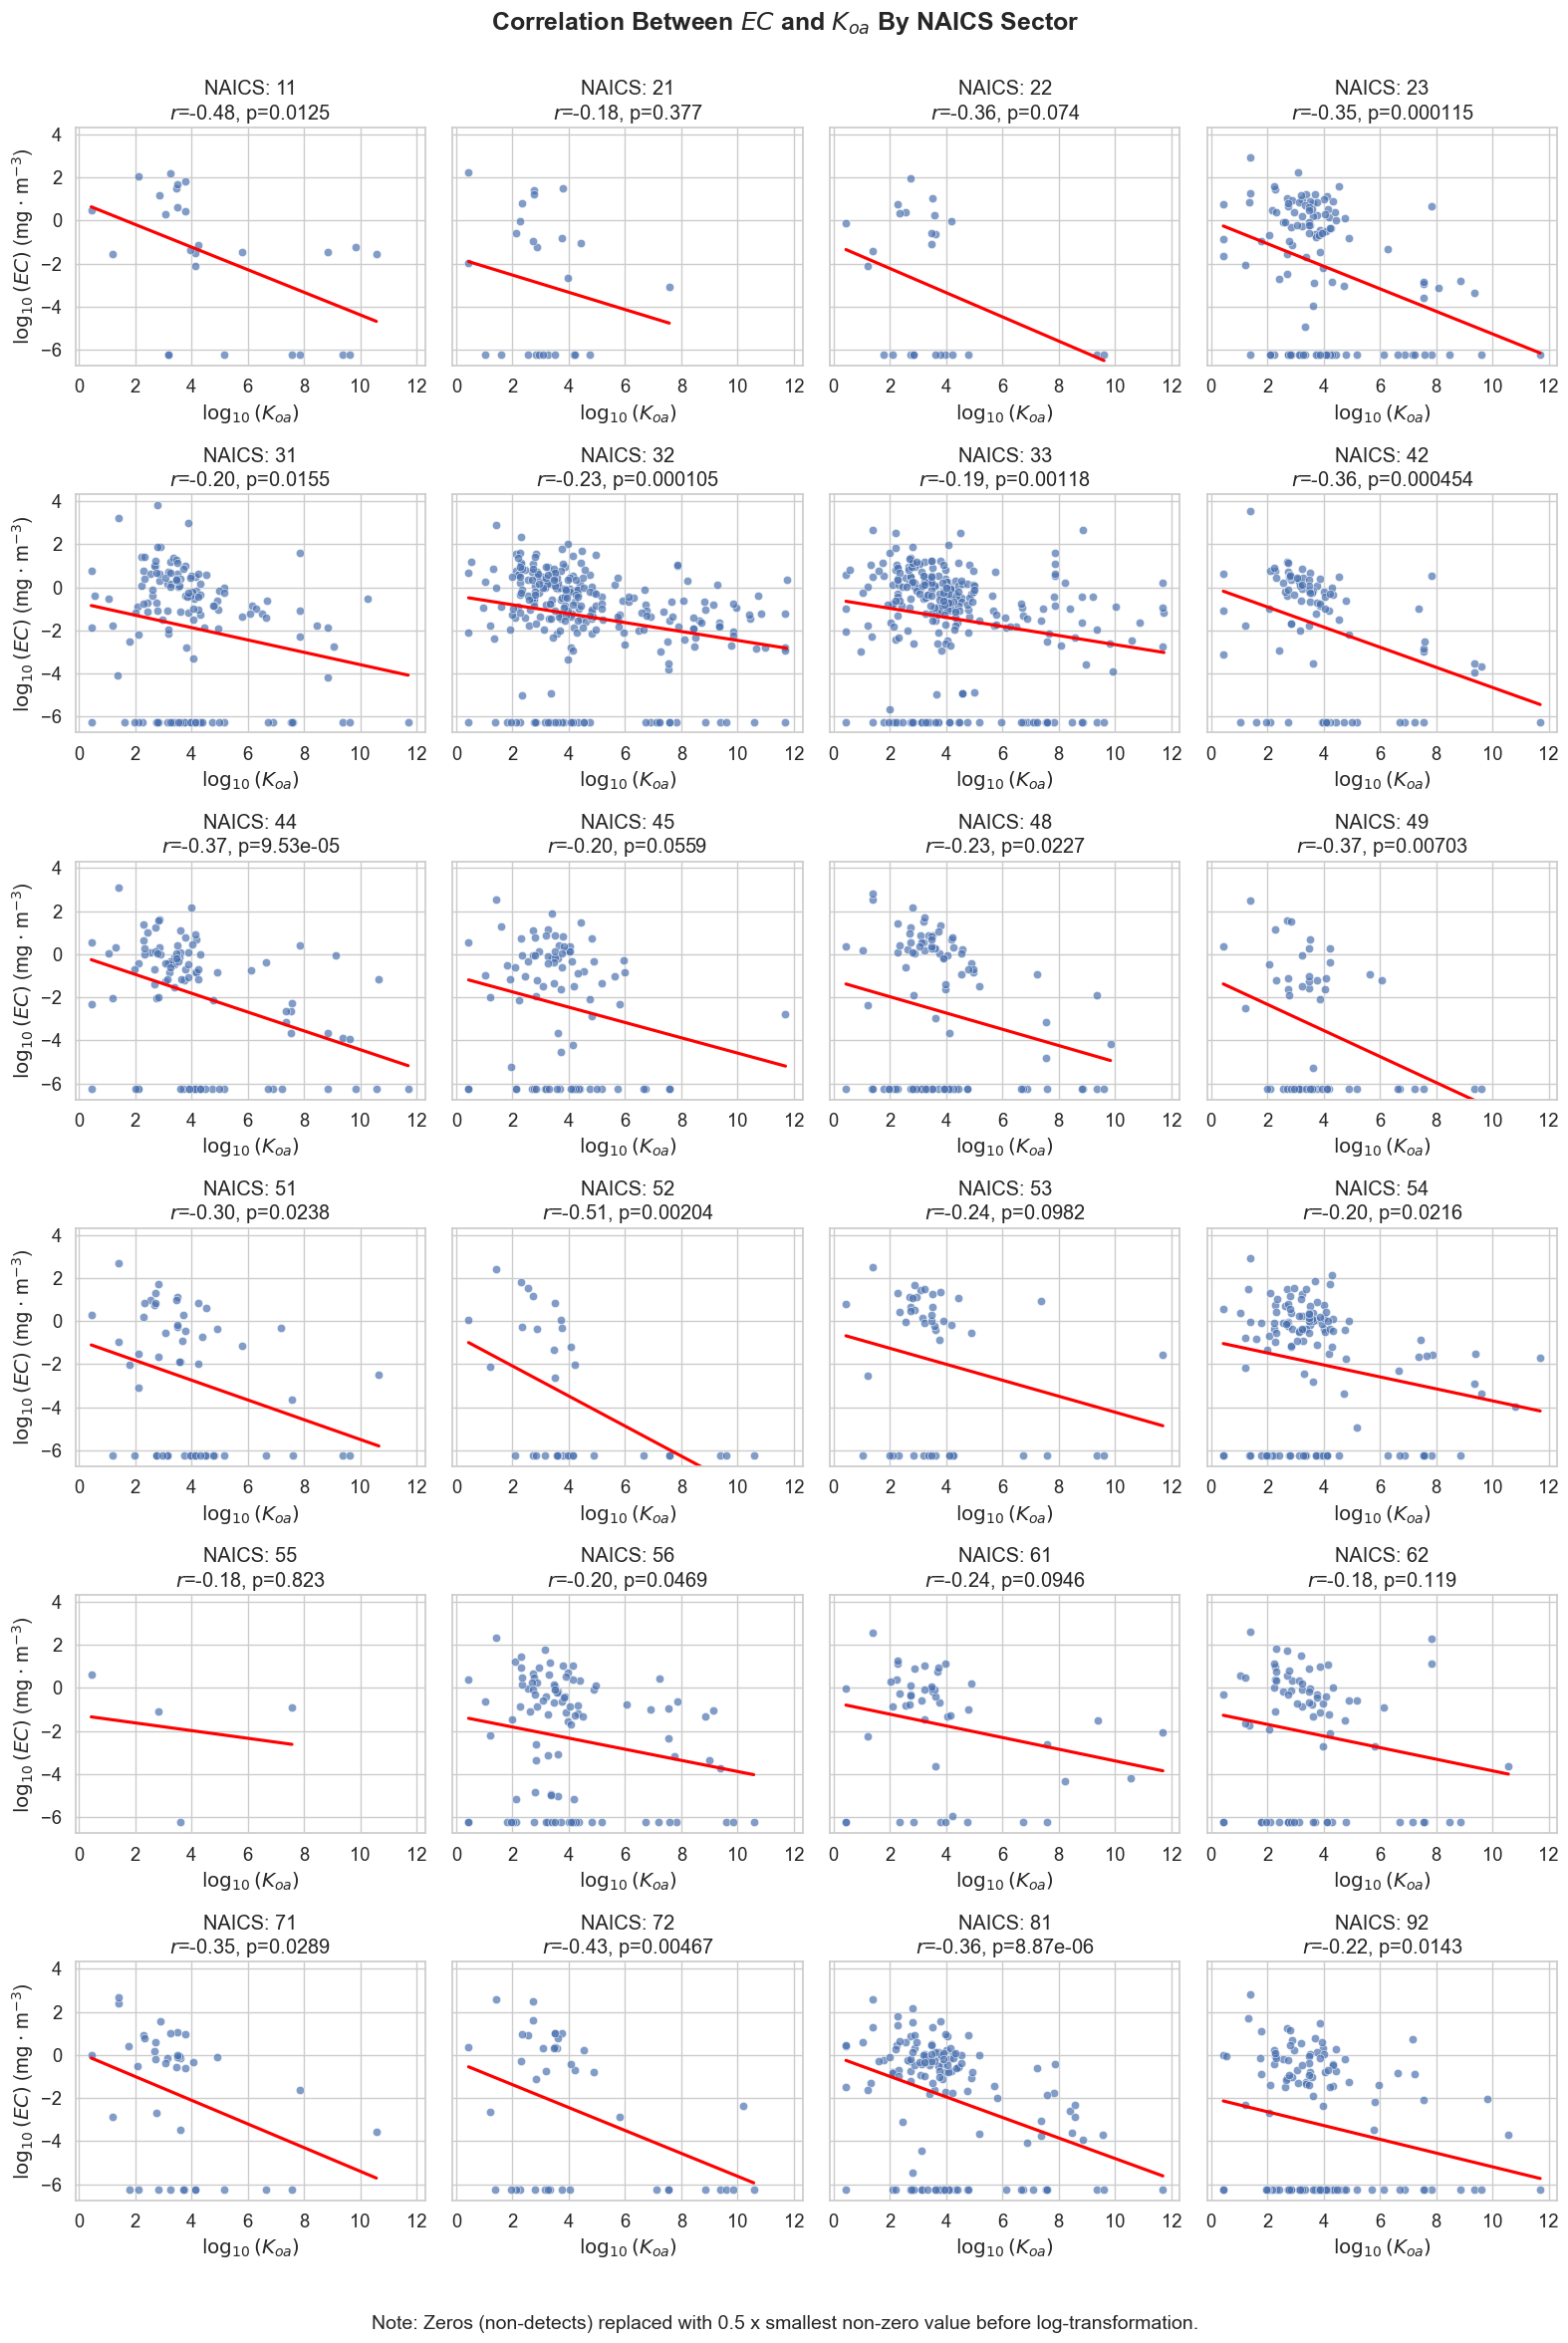

In [4]:
plot.correlation_by_naics(
    combined_targets['sector'],
    opera_features,
    write_path='figures/correlation_by_naics.png'
)

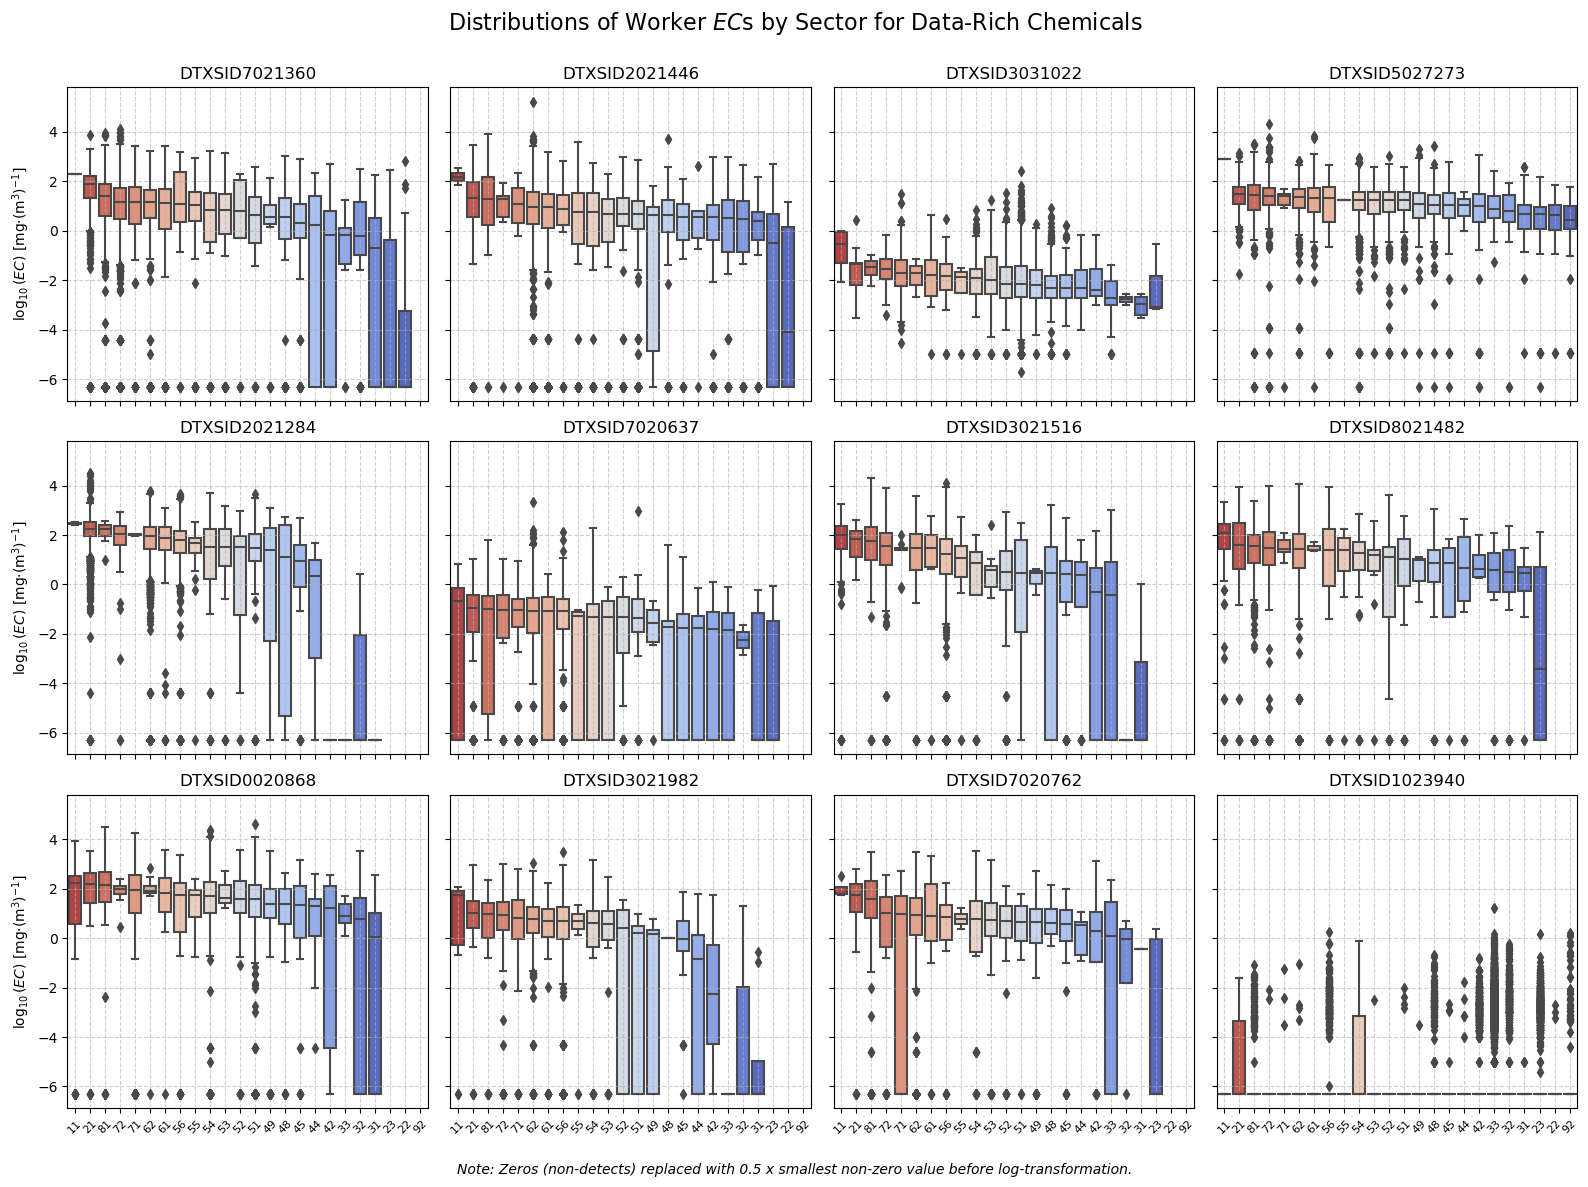

In [3]:
# NOTE: There is a consistent sector trend across all the chemicals

# Get the TWAs on a per worker basis
y_by_sampling_no = osha_processing.reindex_with_naics_level(
    twa_combined.droplevel('inspection_number'), 
    config.usis['naics_code_col'], 
    'sector'
).rename('concentration')

most_data_rich_chemicals = (
    y_by_sampling_no
    .replace(0., np.nan)
    .dropna()
    .groupby('DTXSID')
    .count()
    .sort_values(ascending=False)
    .iloc[:12]
    .index
    .to_list()
)

plot.twa_concentrations_by_naics(
    y_by_sampling_no.loc[most_data_rich_chemicals],
    write_path='figures/twa_concentrations_by_sector.png'
)